In [1]:
from datasets import Dataset, load_dataset, DatasetDict, ClassLabel
import numpy as np
import torch
import pandas as pd

#Seeding for deterministic results i.e. showing same output 
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
unique_labels = ['ANGRY', 'DISAGREE', 'DISAPPOINTED', 'DISLIKE', 'NOT_APPROVE',
       'NOT_CORRECT', 'OTHER', 'PESSIMISTIC', 'WORRIED']
function_labels = ClassLabel(names=unique_labels)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([function_labels.names])
labels_classes = mlb.classes_
labels_classes

array(['ANGRY', 'DISAGREE', 'DISAPPOINTED', 'DISLIKE', 'NOT_APPROVE',
       'NOT_CORRECT', 'OTHER', 'PESSIMISTIC', 'WORRIED'], dtype=object)

In [3]:
function_mapping = {'OTHER': ['admiration', 'approval', 'gratitude', 'amusement', 'curiosity', 'embarrassment', 'love', 'optimism', 'joy', 
                              'realization', 'confusion', 'caring', 'excitement', 'surprise', 'desire', 'pride', 'relief', 'neutral'], 
           'NOT_INTERESTED': [''], 
           'DISLIKE':['disgust', 'annoyance'], 
           'NOT_CORRECT': ['disapproval'], 
           'PESSIMISTIC':['grief', 'remorse', 'sadness'], 
           'WORRIED':['fear', 'nervousness'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': ['disappointment'], 
           'BORED': [''], 
           'NOT_APPROVE':['disapproval'], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': ['disapproval'], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

go_emotions = load_dataset("go_emotions").remove_columns("id")
def adjust_labels(batch):
    batch['emotions'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["labels"]):
        batch["emotions"][i] = [mapping[label] for label in batch["labels"][i]]
    return batch

go_emotions = go_emotions.map(adjust_labels, batched=True)
def map_labels(batch):
    batch['functions'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["emotions"]):
        batch["functions"][i] = [key for key,value in function_mapping.items() if any(emotion in batch["emotions"][i] for emotion in value)]
    return batch
go_emotions = go_emotions.map(map_labels, batched=True).remove_columns("labels")

dataset = DatasetDict({
    "valid": go_emotions['validation'],
    "test": go_emotions['test']
})

# Convert labels to one hot enconding vectors
def one_hot_encoding(batch):
    label_ids = mlb.transform(batch['functions'])
    return {"label_ids":label_ids}
dataset = dataset.map(one_hot_encoding, batched=True)

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (/home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
100%|██████████| 3/3 [00:00<00:00, 829.57it/s]
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-1c4d70c4ecc5a4bd.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-8f90b5d8ac946ce8.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-f0dc721270e34384.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer, TrainingArguments
finetuned_model = 'functions_basic_finetuning_single_label/checkpoint-100/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(finetuned_model,problem_type="multi_label_classification", num_labels = len(labels_classes))).to(device)
tokenizer=AutoTokenizer.from_pretrained(finetuned_model)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)#max_length=512) #for XLM-RoBERTa and emoevent-es, we need to set max_length parameter for this code to work

ds_enc = dataset.map(tokenize, batched=True) #remove_columns=cols)
print(ds_enc)
ds_enc.set_format("torch", columns=["input_ids", "attention_mask", "label_ids"])
ds_enc = (ds_enc
          .map(lambda x : {"float_labels": x["label_ids"].to(torch.float)}, remove_columns=["label_ids"])
          .rename_column("float_labels", "label_ids"))

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-ddf38a2b0db38978.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-58dfe44ecb134960.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-83ef510942efa061.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-e0f6928a892e6ae6.arrow


DatasetDict({
    valid: Dataset({
        features: ['text', 'emotions', 'functions', 'label_ids', 'input_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'emotions', 'functions', 'label_ids', 'input_ids', 'attention_mask'],
        num_rows: 5427
    })
})


In [5]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
    
# source: https://jesusleal.io/2021/04/21/Longformer-multlabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):   
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions)) 
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1   
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_macro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [6]:
args = TrainingArguments(".", num_train_epochs=1)

trainer = Trainer(model=model, args=args, 
                  compute_metrics=compute_metrics,                  
                  eval_dataset=ds_enc['test'],
                  tokenizer=tokenizer)

In [7]:
preds_output = trainer.predict(ds_enc['valid'])
print(preds_output.metrics)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text, functions, emotions. If text, functions, emotions are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5426
  Batch size = 16
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.617808997631073, 'test_f1': 0.17565604957317849, 'test_roc_auc': 0.5637033888515337, 'test_accuracy': 0.015112421673424253, 'test_runtime': 39.9137, 'test_samples_per_second': 135.943, 'test_steps_per_second': 8.518}


In [8]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

macros, micros, macroprecision, macrorecall = [], [], [], []
y_true = np.array(ds_enc['valid']["label_ids"])
thresholds = np.linspace(0.1, 1, 100)
for threshold in thresholds:
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(preds_output.predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1    
    report = classification_report(y_true, y_pred, target_names=labels_classes, zero_division=0, output_dict=True)
    micros.append(report["micro avg"]["f1-score"])
    macros.append(report["macro avg"]["f1-score"])
    macroprecision.append(report['macro avg']['precision'])
    macrorecall.append(report['macro avg']['recall'])

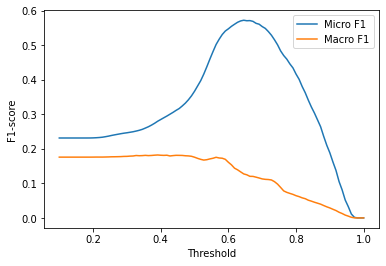

In [9]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

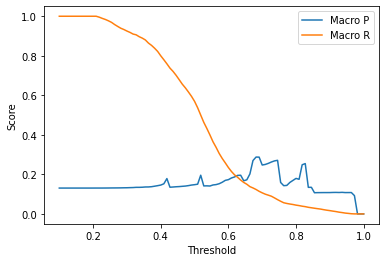

In [10]:
plt.plot(thresholds, macroprecision, label="Macro P")
plt.plot(thresholds, macrorecall, label="Macro R")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [11]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

Best threshold (micro): 0.6454545454545454 with F1-score 0.57.
Best threshold (macro): 0.3909090909090909 with F1-score 0.18.
Best threshold (macro-Precision): 0.6818181818181818 with macroP-score 0.29.
Best threshold (macro-Recall): 0.1 with macroR-score 1.00.


## Experiment with eval/test dataset

In [12]:
#output = trainer.evaluate()
preds_output = trainer.predict(ds_enc['test'])
print(preds_output.metrics)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text, functions, emotions. If text, functions, emotions are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5427
  Batch size = 16
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.6182177662849426, 'test_f1': 0.16988369085658356, 'test_roc_auc': 0.567583560709151, 'test_accuracy': 0.015109637000184264, 'test_runtime': 37.8305, 'test_samples_per_second': 143.456, 'test_steps_per_second': 8.987}


In [13]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(preds_output.predictions))
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= 0.4)]= 1
# finally, compute metrics
y_true = np.array(ds_enc['test']["label_ids"])
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
#classification report using our set of labels
report = classification_report(
  y_true,
  y_pred,
  target_names=labels_classes,
  zero_division=0,
  output_dict=True
)
print(report)

df = pd.DataFrame(report).transpose()
with open(r'classification_report_functions_basic_goemotions_finetuning_threshold=0.4.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

{'ANGRY': {'precision': 0.03650442477876106, 'recall': 1.0, 'f1-score': 0.07043756670224119, 'support': 198}, 'DISAGREE': {'precision': 0.049216589861751155, 'recall': 1.0, 'f1-score': 0.0938158819395643, 'support': 267}, 'DISAPPOINTED': {'precision': 0.11428571428571428, 'recall': 0.026490066225165563, 'f1-score': 0.04301075268817204, 'support': 151}, 'DISLIKE': {'precision': 0.09957557949722494, 'recall': 0.710955710955711, 'f1-score': 0.17468499427262313, 'support': 429}, 'NOT_APPROVE': {'precision': 0.04925290536801328, 'recall': 1.0, 'f1-score': 0.09388185654008438, 'support': 267}, 'NOT_CORRECT': {'precision': 0.053700361010830325, 'recall': 0.8913857677902621, 'f1-score': 0.10129814854224303, 'support': 267}, 'OTHER': {'precision': 0.811548458967694, 'recall': 0.9965800273597811, 'f1-score': 0.8945968072042572, 'support': 4386}, 'PESSIMISTIC': {'precision': 0.0543794105437941, 'recall': 0.6179245283018868, 'f1-score': 0.09996184662342615, 'support': 212}, 'WORRIED': {'precision'

In [14]:
import torch.nn as nn
def loss_fn(outputs, labels):
    if labels is None:
        return None
    loss_values = []
    for f, b in zip(outputs, labels):
        loss_value = nn.BCEWithLogitsLoss()(f, b.float())
        loss_values.append(loss_value)
    torch_loss = torch.tensor(loss_values)
    return torch_loss

def forward_pass_with_label(batch): 
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}      
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits        
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(logits.squeeze().cpu())       
        predictions = np.zeros(probs.shape)
        predictions[np.where(probs >= 0.4)] = 1       
        loss = loss_fn(logits, batch["label_ids"].to(device))
    return {"loss": loss.cpu().numpy(), 
            "pred_label_ids": predictions}

ds_enc.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label_ids"])
ds_enc = ds_enc.map(
    forward_pass_with_label, batched=True, batch_size = 8)

In [15]:
def get_predicted_labels(batch):
    transformed_into_label_names = mlb.inverse_transform(np.array(batch['pred_label_ids']))  
    return  {"predicted_labels": list(map(list, transformed_into_label_names))}
ds_enc.reset_format()
ds_enc['test'] = ds_enc['test'].map(get_predicted_labels, batched=True)

ds_enc.set_format("pandas")
cols = ["text", "emotions", "functions", "predicted_labels", "loss"]
df_test = ds_enc['test'][:][cols]
loss_values = df_test.sort_values("loss", ascending=False).head(50)
print(loss_values)

                                                   text  \
622                                 no one cares my guy   
1035         But but r/49ers said it was just bad luck!   
3466  You're an idiot and no one believes you and yo...   
2995         hey the 5 riders per van per day are upset   
4415  I'm full of envy. Would love to be on that sor...   
3779  My adopted daughter told me, "You can't tell m...   
4831  You just made my point, you obnoxious whining kid   
2866  You spend time in The Donald, do you not under...   
2899  “[NAME] you’re still here? Geez you really are...   
4233                                         oh, my bad   
2438           I always move back and always regret it.   
5031                 You sure seem angry. #itwillbeokay   
4403                                    You ain't wrong   
5073            Oh boy do I have some bad news for you!   
3832  Don't know how that was missed. Tragic really....   
1274  What bothers me is not the fact that someone d... 

In [16]:
loss_values.to_csv('loss_values_functions_basic_finetuning_threshold=0.4.tsv',header =True, sep = '\t',index=False)
df_test.to_csv('preds_functions_basic_finetuning_threshold=0.4.tsv',header =True, sep = '\t',index=False)